# Sequence to Sequence Learning with Neural Networks

**References:**
* [Sequence to Sequence Learning with Neural Networks by Ben Trevtt](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)
* [Language translation with torchtext by PyTorch](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html)
* [Attention? Attention! by Lilian Weng](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#born-for-translation)
* [Sequence to Sequence Learning with Neural Networks by Sutskever et al.](https://arxiv.org/abs/1409.3215)

In [1]:
import time 
import copy
import random
import math
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# fix the random seeds for reproducibility
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

## Introduction

Sequence-to-sequence (**seq2seq**) models aim to transform an input sequence (source) to a new sequence (target), where both sequences can be of arbitrary lengths. Examples of transformation tasks include machine translation between multiple languages, question-answer generation etc. The most common seq2seq models are encoder-decoder architectures using RNNs:

* **Encoder:** encodes the source sentence into a single vector of fixed length - we will call this vector the **contect vector**. This vector can be thought of as an absract representation of the entire source sentence.

* **Decoder:** initialised with the context vector. Learns to output the target sentence by generating it one word at a time. Early work uses the last hidden state of the encoder network as the decoder initial hidden state.


<img src="assets/seq2seq.png" alt="Drawing" style="width: 700px;"/>

The above image shows an example of a translation task. The source sentence "$\texttt{guten morgan}$" is first passed through the embedding layer  (yellow blocks) and used as input to the encoder (green block). We append a start of sequence "$\texttt{<sos>}$" and end of sequence "$\texttt{<eos>}$" token to the start and end of the sentence.

At each timestep, $t$, the input to the encoder RNN is both the embedding of the current token $\mathbf{e}(x_t)\in\mathbb{R}^{k}$ as well as the hidden state from the previous timestep, $\mathbf{h}_{t-1}\in\mathbb{R}^{d}$, where $k$ is the embedding dimension size and $d$ is the number of features in the hidden state. Here the output vector of both the encoder and decoder RNNs is the updated hidden state. The hidden state, $\mathbf{h}_t$, can be thought of as a vector representation of the sentence so far,

$$\mathbf{h}_t=\text{EncoderRNN}\Big(\mathbf{e}(x_t),\mathbf{h}_{t-1}\Big).$$

Here we have that $X=\{x_1,x_2,...,x_T\}$, where $x_1=\texttt{<sos>}$, $x_2=\texttt{guten}$ and so on. The initial hidden state $h_0$ is usually initialised to zeros or is a learned parameter. The above is in the case where we are using a [vanilla RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or a [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html). In the case where we are using a [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) we also have a cell state, $\mathbf{c}_{t-1}\in\mathbb{R}^{d}$,

$$\mathbf{h}_t, \mathbf{c}_t=\text{EncoderRNN}\Big(\mathbf{e}(x_t),\mathbf{h}_{t-1},\mathbf{c}_{t-1}\Big).$$

Once the final token $x_T$ has been passed into the RNN we use the final hidden state $\mathbf{h}_T$ as the context vector, i.e. $\mathbf{z}=\mathbf{h}_T\in\mathbb{R}^{d}$.

Now that we have the context vector we can start decoding it to get the target sentence "$\texttt{good morning}$". Again we append start and end of sequence tokens to the target sentence. At each timestep, $t$, the input to the decoder RNN (blue block) is the embedding of the current token, $\mathbf{e}'(y_t)\in\mathbb{R}^{k'}$, as well as the hidden state from the previous timestep, $\mathbf{s}_{t-1}\in\mathbb{R}^{d}$ (we denote the hidden state of the decoder RNN as $\mathbf{s}$),

$$\mathbf{s}_t=\text{DecoderRNN}\Big(\mathbf{e}'(y_t),\mathbf{s}_{t-1}\Big).$$

where typically $k'=k$. Although in the diagram the source embedding layer, $\mathbf{e}$, and target embedding layer, $\mathbf{e}'$, are both shown in yellow, they are two different embedding layers with their own parameters.

We now map the decoder hidden states, $\mathbf{s}_t$, to words by passing it through a `Linear` layer (shown in purple) where the number of output nodes corresponds to the vocabulary of the target language,

$$\hat{y}_{t+1}=f(\mathbf{s}_t).$$

The words in the decoder are always generated one after another, with one per time-step. We always use $x_1=y_1=$"$\texttt{<sos>}$" for the first input to the decoder, but for subsequent inputs, $x_{t>1}$, we will sometimes use:
1. the ground truth word in the sequence, e.g. $x_2=y_2$ or 
2. the word predicted by our decoder, e.g. $x_2=\hat{y}_2$. 

This is called teacher forcing, see a bit more info about it [here](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/). Hence we have:

* Predicted target sentence is $\hat{Y} = \{ 0, \hat{y}_2, ..., \hat{y}_T \}$, where we do not have a prediction for $\hat{y}_1$ as we use $y_1=$"$\texttt{<sos>}$" as our input, $x_1$, to predict the next word in the sequence, $y_2$.
* Actual target sentence $Y = \{ y_1, y_2, ..., y_T \} = \{\texttt{<sos>}, \texttt{guten}, \texttt{morgan}, ...\}$

We will compare these two sequences to calculate our loss. We then use this loss to update all of the parameters in our model.

## Preparing the Data

We first load our tokenizers using `Spacy`. We use Spacy because it provides strong support for tokenization in languages other than English. `torchtext` provides a `basic_english` tokenizer and supports other tokenizers for English (e.g. Moses) but for language translation - where multiple languages are required - Spacy is your best bet. 

To run this notebook, first install spacy and then download the raw data for the English and German Spacy tokenizers:

```bash
python -m spacy download en
python -m spacy download de
```

We use the `torchtext.data.Field` to structure our data

In [3]:
SRC = Field(tokenize="spacy",
            tokenizer_language="de",
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize="spacy",
            tokenizer_language="en",
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

/home/umeepega/anaconda3/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/umeepega/anaconda3/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Next, we download and load the train, validation and test data from the [Multi30K dataset](https://github.com/multi30k/dataset). This is a dataset with ~$30,000$ parallel English, German and French sentences, each with ~$12$ words per sentence.

In [4]:
train_data, val_data, test_data = Multi30k.splits(exts=('.de', '.en'), 
                                                  fields=(SRC, TRG))
print(f"Number of training examples:   {len(train_data.examples)}")
print(f"Number of validation examples: {len(val_data.examples)}")
print(f"Number of testing examples:    {len(test_data.examples)}")

/home/umeepega/anaconda3/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


Number of training examples:   29000
Number of validation examples: 1014
Number of testing examples:    1000


We next build our vocabulary's for each language

In [5]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


Finally for processing the data we create our iterators using a `BucketIterator` which batches examples of similar lengths together, thus minimising the amount of padding in both source and target sentences.

In [6]:
batch_size = 64
train_iter, val_iter, test_iter = BucketIterator.splits((train_data, val_data, test_data),
                                                        batch_size=batch_size,
                                                        device=device)

/home/umeepega/anaconda3/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Building the seq2seq modelling

### Encoder
Our encoder RNN consists of a 2 layer LSTM as shown below

<img src="assets/two_layer_lstm_encoder.png" alt="Drawing" style="width: 500px;"/>

Notice that we do not pass an initial hidden or cell state to the RNN. This is because, as noted in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM), that if no hidden/cell state is passed to the RNN, it will automatically create an initial hidden/cell state as a tensor of all zeros.

In [7]:
class Encoder(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embed_size, 
                 hidden_size, 
                 num_layers, 
                 dropout):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # define embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=embed_size)
        # define LSTM       
        self.rnn = nn.LSTM(input_size=embed_size, 
                           hidden_size=hidden_size, 
                           num_layers=num_layers, 
                           batch_first=True,
                           dropout=dropout)
        # define dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):
        """
        Parameters:
        -----------
        input : ` torch.Tensor`
            The source sentence, [batch_size, seq_len].
            
        Returns:
        --------
        hidden : `torch.Tensor`
            The hidden state of the LSTM [num_layers, batch_size, hidden_size].
        cell : `torch.Tensor`
            The cell state of the LSTM [num_layers, batch_size, hidden_size].            
        """        
        # encode the input using embedding layer
        x = self.dropout(self.embedding(input)) # [batch_size, seq_len, embed_size]
        # pass through LSTM
        # x here is the hidden states from the top LSTM layer
        x, (hidden, cell) = self.rnn(x) # x : [batch_size, seq_len, hidden_size] 
        return hidden, cell

### Decoder

Our decoder RNN consists of a 2 layer LSTM as shown below

<img src="assets/two_layer_lstm_decoder.png" alt="Drawing" style="width: 300px;"/>

Here we are only decoding one token at a time, thus the input tokens will always have a sequence length of $1$.

In [8]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_size, 
                 embed_size, 
                 hidden_size, 
                 num_layers, 
                 dropout):
        super().__init__()
        
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        #  define embedding layer
        self.embedding = nn.Embedding(num_embeddings=output_size, 
                                      embedding_dim=embed_size)
        # define LSTM
        self.rnn = nn.LSTM(input_size=embed_size, 
                           hidden_size=hidden_size, 
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout)
        # define fully connected layer
        self.fc_out = nn.Linear(hidden_size, output_size)
        # define dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        """
        Parameters:
        -----------
        input : ` torch.Tensor`
            The source sentence, [batch_size].
        hidden : `torch.Tensor`
            The hidden state of the LSTM [num_layers, batch_size, hidden_size].
        cell : `torch.Tensor`
            The cell state of the LSTM [num_layers, batch_size, hidden_size].             
            
        Returns:
        --------
        x : `torch.Tensor`
            The predictions, [batch_size, output_size].
        hidden : `torch.Tensor`
            The hidden state of the LSTM [num_layers, batch_size, hidden_size].
        cell : `torch.Tensor`
            The cell state of the LSTM [num_layers, batch_size, hidden_size].            
        """          
        # add seq_len=1 dimension
        x = input.unsqueeze(1) # [batch_size, 1]
        # encode the input using the embedding layer
        x = self.dropout(self.embedding(x)) # [batch_size, 1, embed_size]
        # pass through LSTM        
        x, (hidden, cell) = self.rnn(x, (hidden, cell)) # [batch_size, 1, hidden_size] and [num_layers, batch_size, hidden_size]
        # pass through fully connected layer
        x = self.fc_out(x.squeeze(1))
        return x, hidden, cell

### Seq2Seq

Our full model looks like 

<img src="assets/two_layer_seq2seq.png" alt="Drawing" style="width: 700px;"/>

For this implementation we need to ensure the number of layers and the hidden and cell state dimension sizes are equal in the Encoder and Decoder. This is not necessary but for simplicity this is what we choose to do. 

When decoding, at each timestep, $t$, we will predict what the token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(\mathbf{s}^{n}_t)$, where $\mathbf{s}^{n}_t$ is the hidden state from the final LSTM layer. With probability equal to the `teacher_forcing_ratio` we will use the actual ground-truth token in the target sequence, as the input to the decoder during the next timestep, $x_{t+1}=y_{t+1}$. However, with probability $1 -$ `teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, $x_{t+1}=\hat{y}_{t+1}$, even if it doesn't match the actual next token in the target sequence.

As stated before the first input to the decoder is $x_1=y_1=$"$\texttt{<sos>}$". In the batch we know how long our target sentence will be from `max_len` and so loop through that many times. The last token input to the decoder is the one **before** "$\texttt{<eos>}$". The "$\texttt{<eos>}$" is never input into the decoder. During each iteration of the decoder loop:
1. $x_1=y_1=$"$\texttt{<sos>}$", $\mathbf{s}_0=\mathbf{h}_T$ and $\mathbf{c}^{DECODER}_0=\mathbf{c}^{ENCODER}_T$.
2. Pass $(x_t, \mathbf{s}_{t-1}, \mathbf{c}_{t-1})$ into the decoder.
3. Receive $(\hat{y}_{t+1}, \mathbf{s}_t, \mathbf{c}_t)$ from the decoder.
4. Place prediction $\hat{y}_{t+1}$ in out tensor of predictions $\hat{Y}$.
5. Decide if we are using teaching forcing:
    * Yes, then set $x_{t+1}=y_{t+1}$
    * No, then set $x_{t+1}=\hat{y}_{t+1}$, where $\hat{y}_{t+1}$ is chosen using an `argmax` over all the words.
    
**NOTE:** The above is achieved as the decoder loop starts at $1$ not $0$. This means the zeroth elements of our prediction vector will be all zeros.

$$\begin{align*}
 \text{target}&=\{\texttt{<sos>},y_2, y_3,\texttt{<eos>}\}\\
 \text{predictions}&=\{0,\hat{y}_2, \hat{y}_3,\hat{y}_4\}
\end{align*}$$

When calculating the loss we will cut off the first element of each tensor to get

$$\begin{align*}
 \text{target}&=\{y_2, y_3,\texttt{<eos>}\}\\
 \text{predictions}&=\{\hat{y}_2, \hat{y}_3,\hat{y}_4\}
\end{align*}$$

### Side Note (not implemented here)
One improvement to this model would be instead of the decoder only taking as input the embedded target token, $\mathbf{e}'(y_t)$, and the previous hidden state, $\mathbf{s}_{t-1}$, it also takes the context vector $\mathbf{z}$,

$$\mathbf{s}_t=\text{DecoderRNN}\Big(\mathbf{e}'(y_t),\mathbf{s}_{t-1}, \mathbf{z}\Big).$$

Note that the context vector, $\mathbf{z}$, does not have a $t$ subscript. This means we use the same context vector returned by the encoder for every timestep in the decoder. Additionally, before we predicted the next token, $\hat{y}_{t+1}$, with the linear layer, $f(\cdot)$, as $\hat{y}_{t+1}=f(\mathbf{s}^{n}_t)$. Now, we also pass the embedding of the current token, $\mathbf{e}'(y_t)$ and the context vector, $\mathbf{z}$ to the linear layer,

$$\hat{y}_{t+1} = f\Big(\mathbf{e}'(y_t), \mathbf{s}_t, \mathbf{z}\Big)$$

These two modification help alleviate the information compression as suggested in [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation by Cho et al.](https://arxiv.org/abs/1406.1078)

<img src="assets/better_seq2seq.png" alt="Drawing" style="width: 700px;"/>

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
        # intialise model weights
        self.init_weights()
        
    def forward(self, 
                X, 
                Y, 
                teacher_forcing_ratio=0.5):
        """
        Parameters:
        -----------
        X : ` torch.Tensor`
            The source sentence, [batch_size, src_len].
        Y : ` torch.Tensor`
            The target sentence, [batch_size, trg_len].            
        teacher_forcing_ratio : `float`
            The probability to use teacher forcing, 
            i.e. if 0.5 then we use the ground-truth inputs 75% of the time.
            
        Returns:
        --------
        preds : `torch.Tensor`
            The predictions, [batch_size, trg_len, trg_vocab_size].       
        """          
        batch_size = X.size(0)
        max_len = Y.size(1)
        Y_vocab_size = self.decoder.output_size
        
        # tensor to store decoder outputs
        preds = torch.zeros(batch_size, max_len, Y_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(X)
        
        # first input to the decoder is the <sos> tokens
        input = Y[:, 0]
        for t in range(1, max_len):
            # pass through decoder
            pred, hidden, cell = self.decoder(input, hidden, cell)
            # place predictions in a tensor holding predictions
            preds[:, t].copy_(pred)
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = pred.argmax(1) 
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = Y[:, t] if teacher_force else top1
        return preds
    
    def init_weights(self):
        """
        Initialise the weights and biases of the network.
        """
        for name, param in self.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0)
            elif 'weight' in name:
                nn.init.uniform_(param.data, -0.08, 0.08)

## Training

We use the `nn.CrossEntropyLoss` function which calculates both the log softmax and the negative log-likelihood of our predictions. The loss function calculates the average loss per token. By passing the index of the $\texttt{<pad>}$ token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token.

In [10]:
def train(model, 
          train_iter, 
          val_iter, 
          epochs, 
          learning_rate, 
          clip,
          device):
    """
    Fit model with the training data and validate using the validation data.
    
    Parameters:
    -----------
    model : `torch.nn.Module` 
        The model.
    train_iter : `torchtext.data.iterator.BucketIterator`
        The training data iterator.
    val_iter : `torchtext.data.iterator.BucketIterator`
        The validation data iterator.
    learning_rate : `float`
        The learning rate.
    clip : `float`
        Value for clipping the gradients by.
    device : `torch.device`
        Whether working on GPU or CPU.
        
    Returns:
    -------
    measures : `dict` of `list`s
        Dictionary of training and validation 
        losses for each epoch.
    """  
    # send model to gpu or cpu
    model.to(device)
    # set model to train mode    
    model.train()        

    # initialise optimiser
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # initialise loss function: cross-entropy loss
    criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])           
    
    measures = defaultdict(list)
    best_model = copy.deepcopy(model)
    best_val = np.inf
    for epoch in range(epochs):
        
        start_time = time.time()
        train_loss =  0

        for i, batch in enumerate(train_iter):          
            x, y = batch.src.T, batch.trg.T  # [batch_size, seq_len]
            
            # zero accumulated gradients
            optimiser.zero_grad()
            
            # forward Propogation: get prediction from model
            preds = model(x, y) # [batch_size, seq_len, output_size]
            
            # calculate the loss
            loss = criterion(preds[:, 1:].reshape(-1, model.decoder.output_size), 
                             y[:, 1:].reshape(-1))              
       
            # backpropogation: calculating gradients
            loss.backward()
            # prevent the exploding gradient problem in RNNs/LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            # update weights
            optimiser.step()
            
            # append the train loss
            train_loss += loss.item()    
            
        # set model to evaluate mode
        model.eval()         
        # monitor the validation loss
        val_loss = 0
        with torch.no_grad():
            for j, batch in enumerate(val_iter):                    
                x, y = batch.src.T, batch.trg.T # [batch_size, seq_len]
                # get validation prediction
                preds = model(x, y, 0) # turn off teacher forcing          
                # get validaiton loss
                loss = criterion(preds[:, 1:].reshape(-1, model.decoder.output_size), 
                                 y[:, 1:].reshape(-1)) 
                # add the validation loss
                val_loss += loss.item()     
                
        # put model to train mode
        model.train()      
        
        # save losses from epoch
        train_loss /= len(train_iter)
        val_loss /= len(val_iter)
        measures["Train loss"].append(train_loss)
        measures["Val loss"].append(val_loss)     
        
        print("Epoch: {}/{}".format(epoch+1, epochs), "|", "Time Taken: {:,.4f} seconds".format(time.time()-start_time)) 
        print("\tTrain Loss: {:.4f}".format(train_loss), "|", "Val Loss: {:.4f}".format(val_loss))
        print("\tTrain PPL:  {:.4f}".format(math.exp(train_loss)), "|", "Val PPL:  {:.4f}".format(math.exp(val_loss)))

        # save best model
        if measures["Val loss"][-1] < best_val:
            best_val = measures["Val loss"][-1]
            best_model = copy.deepcopy(model)
            
        # early stopping condition for convergence on validation.
        win_size = 10
        threshold = 0.00005        
        try:
            curr_avg = np.mean(measures["Val loss"][-1-win_size:-1])
            prev_avg = np.mean(measures["Val loss"][-win_size*2:-win_size])
            if np.absolute(curr_avg - prev_avg) < threshold:
                break
        except:
            pass 
        
    return best_model, measures

In [11]:
# hyperparameters of model
src_vocab_size = len(SRC.vocab)
trg_vocab_size = len(TRG.vocab)
enc_embed_size = 256
dec_embed_size = 256
hidden_size = 512
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

# hyperparameters for training
epochs = 20
learning_rate = 1e-3
clip = 1

In [12]:
# initialsie the encoder model
encoder = Encoder(vocab_size=src_vocab_size, 
                  embed_size=enc_embed_size, 
                  hidden_size=hidden_size, 
                  num_layers=num_layers, 
                  dropout=enc_dropout)
# initialise the decoder model 
decoder = Decoder(output_size=trg_vocab_size, 
                  embed_size=dec_embed_size, 
                  hidden_size=hidden_size, 
                  num_layers=num_layers, 
                  dropout=dec_dropout)
# initialise seq2seq model
model = Seq2Seq(encoder=encoder,
                decoder=decoder,
                device=device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


In [13]:
# train the model
best_model, measures = train(model=model, 
                             train_iter=train_iter, 
                             val_iter=val_iter, 
                             epochs=epochs, 
                             learning_rate=learning_rate, 
                             clip=clip,
                             device=device)

/home/umeepega/anaconda3/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 1/20 | Time Taken: 52.3700 seconds
	Train Loss: 4.8886 | Val Loss: 4.9377
	Train PPL:  132.7732 | Val PPL:  139.4440


/home/umeepega/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/umeepega/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 2/20 | Time Taken: 52.3627 seconds
	Train Loss: 4.3374 | Val Loss: 4.7624
	Train PPL:  76.5103 | Val PPL:  117.0285
Epoch: 3/20 | Time Taken: 44.2823 seconds
	Train Loss: 4.0298 | Val Loss: 4.4730
	Train PPL:  56.2506 | Val PPL:  87.6188
Epoch: 4/20 | Time Taken: 46.5141 seconds
	Train Loss: 3.7743 | Val Loss: 4.2544
	Train PPL:  43.5682 | Val PPL:  70.4162
Epoch: 5/20 | Time Taken: 48.5205 seconds
	Train Loss: 3.5798 | Val Loss: 4.0765
	Train PPL:  35.8673 | Val PPL:  58.9380
Epoch: 6/20 | Time Taken: 49.0844 seconds
	Train Loss: 3.3844 | Val Loss: 3.9257
	Train PPL:  29.4991 | Val PPL:  50.6887
Epoch: 7/20 | Time Taken: 48.9034 seconds
	Train Loss: 3.2236 | Val Loss: 3.8718
	Train PPL:  25.1174 | Val PPL:  48.0271
Epoch: 8/20 | Time Taken: 49.0374 seconds
	Train Loss: 3.0790 | Val Loss: 3.7680
	Train PPL:  21.7360 | Val PPL:  43.2927
Epoch: 9/20 | Time Taken: 48.9818 seconds
	Train Loss: 2.9429 | Val Loss: 3.7612
	Train PPL:  18.9705 | Val PPL:  42.9984
Epoch: 10/20 | Time Tak

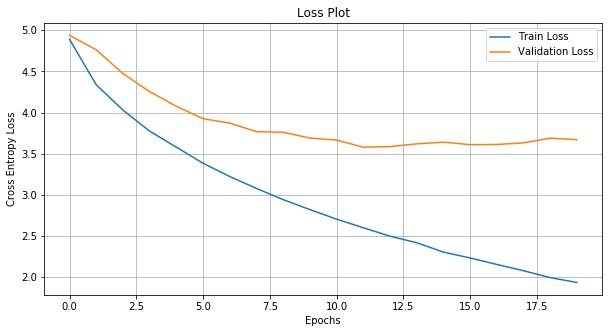

In [14]:
# Plot train and validation loss
plt.figure(figsize=(10,5))
plt.plot(measures["Train loss"], label="Train Loss")
plt.plot(measures["Val loss"], label="Validation Loss")
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid()
plt.show()

## Evaluation

Evaluate the model on the test data.

In [15]:
def evaluate(model, 
             test_iter, 
             device):
    """
    Evaluate model on data and calculate accuracy.
    
    Parameters:
    -----------
    model : `torch.nn.Module` 
        The model.
    test_iter : `torchtext.data.iterator.BPTTIterator`
        The test data iterator.
    device : `torch.device`
        Whether working on GPU or CPU.
        
    Returns:
    -------
    loss : `float`
        The loss of the model on the data predicted over
    ppl : `float`
        The perplexity of the model on the data predicted over        
    """    
    # send model to device
    model.to(device)
    # set to evaluate mode
    model.eval()    
    
    # initialise loss function: cross-entropy loss
    criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])      
            
    # accuracy stats after every epoch
    eval_loss = 0   
    with torch.no_grad():
        for i, batch in enumerate(test_iter):
            x, y = batch.src.T, batch.trg.T # [batch_size, seq_len]
            # get validation prediction
            preds = model(x, y, 0)  # turn off teacher forcing  
            # get validaiton loss
            loss = criterion(preds[:, 1:].reshape(-1, model.decoder.output_size), 
                             y[:, 1:].reshape(-1)) 
            # add the evaluation loss
            eval_loss += loss.item()                 
    loss = eval_loss / len(test_iter)            
    ppl = math.exp(loss)
    return loss, ppl

In [16]:
train_loss, train_ppl = evaluate(model=best_model, 
                                 test_iter=train_iter, 
                                 device=device)
val_loss, val_ppl = evaluate(model=best_model, 
                             test_iter=val_iter, 
                             device=device)
test_loss, test_ppl = evaluate(model=best_model, 
                               test_iter=test_iter,  
                               device=device)

print("Train Loss: {:.4f}".format(train_loss), "|", "Train PPL: {:.4f}".format(train_ppl))
print("Val Loss: {:.4f}".format(val_loss), "|", "Val PPL: {:.4f}".format(val_ppl))
print("Test Loss: {:.4f}".format(test_loss), "|", "Test PPL: {:.4f}".format(test_ppl))

Train Loss: 3.1531 | Train PPL: 23.4078
Val Loss: 3.5794 | Val PPL: 35.8503
Test Loss: 3.5753 | Test PPL: 35.7061
